# Z3 subsystem code

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, List, Dict, Any, Set, FrozenSet, Iterable, Tuple
import math
import random
import networkx as nx
import sympy as sym

import pandas as pd
import os
import galois

In [20]:
def torus(c: complex, distance: int) -> complex:
    """Apply toroidal topology to a point on the lattice."""
    r = c.real % (distance * 4)
    i = c.imag % (distance * 6)
    return r + i*1j

def sorted_complex(xs: Iterable[complex]) -> List[complex]:
    """Sort a list of complex numbers."""
    return sorted(xs, key=lambda v: (v.real, v.imag))

def int_to_pauli(i: int) -> str:
    """Convert an integer to a Pauli operator."""
    pauli_dict = {0: "X", 1: "Y", 2: "Z"}
    if i not in pauli_dict:
        raise ValueError('Integer must be 0, 1, or 2')
    return pauli_dict[i]

def initialize_hex_centers(distance: int) -> Dict[complex, int]:
    """Initialize the hex centers on the lattice."""
    hex_centers = {}
    for row in range(3 * distance):
        for col in range(2 * distance):
            center = row * 2j + 2 * col - 1j * (col % 2)
            category = (-row - col % 2) % 3
            hex_centers[torus(center, distance=distance)] = category
    return hex_centers

def categorize_hexes(hex_centers: Dict[complex, int]) -> Tuple[List[complex], List[complex], List[complex]]:
    """Categorize hexes into red, green, and blue."""
    red_hexes = [h for h, category in hex_centers.items() if category == 0]
    green_hexes = [h for h, category in hex_centers.items() if category == 1]
    blue_hexes = [h for h, category in hex_centers.items() if category == 2]
    return red_hexes, green_hexes, blue_hexes

def get_rgb_hexes(distance: int) -> Tuple[List[complex], List[complex], List[complex]]:
    """Get the red, green, and blue hexes."""
    hex_centers = initialize_hex_centers(distance=distance)
    red_hexes, green_hexes, blue_hexes = categorize_hexes(hex_centers=hex_centers)
    return red_hexes, green_hexes, blue_hexes


### lets define a qubit-plaquette dictionary:
def qubits_in_plaquettes(d):
    QUBITS_AROUND_HEX = [
        (-1 - 1j),
        (+1 - 1j),
        (+1),
        (+1 + 1j),
        (-1 + 1j),
        (-1)
    ]
    hexes = initialize_hex_centers(d)
    qubit_dictionary = {}
    for hex in hexes:
        qubit_coordinates = set()
        for qubit in QUBITS_AROUND_HEX:
            q = hex + qubit
            qubit_coordinates.add(torus(q,d))

        qubit_dictionary[hex] = qubit_coordinates

    return qubit_dictionary


def neighbors(qubits1: set, qubits2: set):
    share_qubit = False
    if not qubits1.isdisjoint(qubits2):
        share_qubit=True
    return share_qubit

In [49]:
d = 3
r_hex, g_hex, b_hex = get_rgb_hexes(d) 
qubits_for_plaq = qubits_in_plaquettes(d)



In [73]:
qubits_for_plaq

{0j: {(1+0j), (1+17j), (1+1j), (11+0j), (11+17j), (11+1j)},
 (2+17j): {(1+0j), (1+16j), (1+17j), (3+0j), (3+16j), (3+17j)},
 (4+0j): {(3+0j), (3+17j), (3+1j), (5+0j), (5+17j), (5+1j)},
 (6+17j): {(5+0j), (5+16j), (5+17j), (7+0j), (7+16j), (7+17j)},
 (8+0j): {(7+0j), (7+17j), (7+1j), (9+0j), (9+17j), (9+1j)},
 (10+17j): {(11+0j), (11+16j), (11+17j), (9+0j), (9+16j), (9+17j)},
 2j: {(1+1j), (1+2j), (1+3j), (11+1j), (11+2j), (11+3j)},
 (2+1j): {(1+0j), (1+1j), (1+2j), (3+0j), (3+1j), (3+2j)},
 (4+2j): {(3+1j), (3+2j), (3+3j), (5+1j), (5+2j), (5+3j)},
 (6+1j): {(5+0j), (5+1j), (5+2j), (7+0j), (7+1j), (7+2j)},
 (8+2j): {(7+1j), (7+2j), (7+3j), (9+1j), (9+2j), (9+3j)},
 (10+1j): {(11+0j), (11+1j), (11+2j), (9+0j), (9+1j), (9+2j)},
 4j: {(1+3j), (1+4j), (1+5j), (11+3j), (11+4j), (11+5j)},
 (2+3j): {(1+2j), (1+3j), (1+4j), (3+2j), (3+3j), (3+4j)},
 (4+4j): {(3+3j), (3+4j), (3+5j), (5+3j), (5+4j), (5+5j)},
 (6+3j): {(5+2j), (5+3j), (5+4j), (7+2j), (7+3j), (7+4j)},
 (8+4j): {(7+3j), (7+4j), (7+5

In [72]:
r_hex

[0j,
 (4+0j),
 (8+0j),
 (2+3j),
 (6+3j),
 (10+3j),
 6j,
 (4+6j),
 (8+6j),
 (2+9j),
 (6+9j),
 (10+9j),
 12j,
 (4+12j),
 (8+12j),
 (2+15j),
 (6+15j),
 (10+15j)]

# Lets define graph:

In [71]:
T = nx.Graph()

R_nodes,G_nodes,B_nodes = [[],[],[]]

#add check qubits
for node, node_pos in enumerate(r_hex):
    T.add_node(node, pos=(node_pos.real, node_pos.imag),color = 'red',xy = node_pos, label = '$p_{'+str(node)+'}$')
    R_nodes.append(node)
for node, node_pos in enumerate(g_hex):
    T.add_node(node + len(r_hex), pos=(node_pos.real, node_pos.imag), color = 'green', xy = node_pos, label = '$p_{'+str(node)+'}$')
    G_nodes.append(node+len(r_hex))
for node, node_pos in enumerate(b_hex):
    T.add_node(node + len(r_hex)+len(g_hex), pos=(node_pos.real, node_pos.imag), color = 'blue', xy = node_pos, label = '$p_{'+str(node)+'}$')
    B_nodes.append(node + len(r_hex)+len(g_hex))


# add data qubits
data_counter = 0
data_nodes = []
for node_r in R_nodes:
    xy_r =T.nodes[node_r]['xy']

##Red and Green data qubits
    for node_g in G_nodes :
        xy_g = T.nodes[node_g]['xy']
        
        y_data_bits = qubits_for_plaq[xy_r].intersection(qubits_for_plaq[xy_g])
        if len(y_data_bits)>0:
            for y_bit in y_data_bits:
                data_counter+=1
                T.add_node(-data_counter, pos = (y_bit.real, y_bit.imag), type = 'X', xy = y_bit)

                T.add_edge(node_r, -data_counter, label = 'X')
                T.add_edge(node_g, -data_counter, label = 'X')

                data_nodes.append(-data_counter)

##Red and Blue data qubits
    for node_b in B_nodes :
        xy_b = T.nodes[node_b]['xy']
        
        y_data_bits = qubits_for_plaq[xy_r].intersection(qubits_for_plaq[xy_b])
        if len(y_data_bits)>0:
            for y_bit in y_data_bits:
                data_counter+=1
                T.add_node(-data_counter, pos = (y_bit.real, y_bit.imag), type = 'Y', xy = y_bit)

                T.add_edge(node_r, -data_counter, label = 'Y')
                T.add_edge(node_b, -data_counter, label = 'Y')

                data_nodes.append(-data_counter)
    

##Blue and Green data qubits   
for node_b in B_nodes :
        xy_b = T.nodes[node_b]['xy']
        
        for node_g in G_nodes :
            xy_g = T.nodes[node_g]['xy']
            
            y_data_bits = qubits_for_plaq[xy_b].intersection(qubits_for_plaq[xy_g])
            if len(y_data_bits)>0:
                for y_bit in y_data_bits:
                    data_counter+=1
                    T.add_node(-data_counter, pos = (y_bit.real, y_bit.imag), type = 'X', xy = y_bit)

                    T.add_edge(node_b, -data_counter, label = 'Z')
                    T.add_edge(node_g, -data_counter, label = 'Z')

                    data_nodes.append(-data_counter)


        

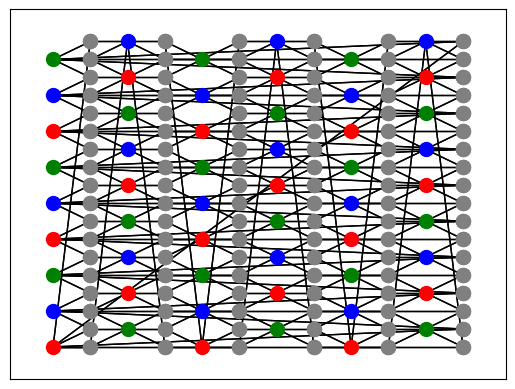

In [42]:
pl = nx.get_node_attributes(T, 'pos')
#lbls = nx.get_edge_attributes(T, 'pos' )

nx.draw_networkx_nodes(T, pos = pl, nodelist=R_nodes, node_color='red', node_size=100)
nx.draw_networkx_nodes(T, pos = pl, nodelist=G_nodes, node_color='green', node_size=100)
nx.draw_networkx_nodes(T, pos = pl, nodelist=B_nodes, node_color='blue', node_size=100)
nx.draw_networkx_nodes(T, pos = pl, nodelist=data_nodes, node_color='grey', node_size=100)
#nx.draw_networkx_labels(T, pos=pl, labels=pl)
nx.draw_networkx_edges(T, pos = pl)

# Need to figure out how to encode logical

* need a data qubit pos -> node dictionary

Lets get a list of qubits

In [69]:
data_qubit_list = set()
for node in R_nodes:
    check_pos = T.nodes[node]['xy']
    for data_qubit in qubits_for_plaq[check_pos]:
        data_qubit_list.add(data_qubit)

data_qubit_list = sorted_complex(data_qubit_list)

logical1 = []
for pos in data_qubit_list[0:6*d]:
    if pos.imag % 3 ==0:
        logical1.append([pos,'X'])
    elif pos.imag % 3 ==1:
        logical1.append([pos,'Y'])
    else:
        logical1.append([pos,'Z'])

Now we have to match with our list of nodes

In [70]:
logical1_nodes = []

for 

[[(1+0j), 'X'],
 [(1+1j), 'Y'],
 [(1+2j), 'Z'],
 [(1+3j), 'X'],
 [(1+4j), 'Y'],
 [(1+5j), 'Z'],
 [(1+6j), 'X'],
 [(1+7j), 'Y'],
 [(1+8j), 'Z'],
 [(1+9j), 'X'],
 [(1+10j), 'Y'],
 [(1+11j), 'Z'],
 [(1+12j), 'X'],
 [(1+13j), 'Y'],
 [(1+14j), 'Z'],
 [(1+15j), 'X'],
 [(1+16j), 'Y'],
 [(1+17j), 'Z']]